# 3. Stablishing Comunication with the NCBI through API
## 3.1. Configuration and link
A configuration file is made in py which corresponds to the details of the comunication and will be stored in gitignore.

# 1 Sequences Scrapping - Introduction
This notebook is an automated tool designed for retrieving 16S rRNA sequences from the GenBank database, managed by the National Center for Biotechnology Information (NCBI). The focus is on sequences associated with various genera found in water bodies, as part of a broader study.

# Key Steps and Features:
### Reading Genera List:
The script starts by reading a list of genera from an Excel file. These genera are of particular interest for the study.
### NCBI Database Interaction:
It establishes a connection with the NCBI database and iteratively queries each genus. This process involves fetching the unique identifiers (accession numbers) of the relevant 16S rRNA sequences.
### Data Storage and Organization:
The retrieved data, mainly accession numbers, are stored in a dictionary for subsequent processing.
### Sequence Retrieval and Verification:
The notebook includes a function for fetching the actual sequence data from GenBank using the accession numbers. There's also a provision for validating the retrieved sequences.
### Data Manipulation:
Extensive data manipulation is performed, including transforming and merging dataframes to align the sequence data with the original genera list.
### Phylogenetic Analysis:
The primary goal is to align these sequences to construct a dendrogram, offering insights into the genomic relationships among the genera.
The notebook implements the UPGMA (Unweighted Pair Group Method with Arithmetic Mean) method for tree construction, with a mention of the possibility of using Neighbor-Joining (NJ).
The script includes steps for sequence alignment, conversion to FASTA format, and preparation for phylogenetic tree construction.
### Bootstrap Analysis for Tree Reliability:
To assess the reliability of the phylogenetic trees, a bootstrap analysis is performed. This involves generating multiple pseudo-replicated datasets and analyzing the resulting tree structures.
### Consensus Tree Construction:
A consensus tree is constructed from the bootstrap trees, providing a robust representation of the phylogenetic relationships.
### Additional Notes:
The script contains several safety and optimization measures, such as using time.sleep to avoid overloading the NCBI server and handling exceptions during sequence retrieval.
There's a focus on improving the script, including suggestions for secure API key storage, error handling enhancements, and code documentation.

I am having problems installilng packages from the terminal, so I am installing the biophyton from here.

# 2. Preprocessing the data 
This notebook has been worked in colab and in vsc, the code is silence eitherway.
## 2.1 Mounting the data in colab

In [1]:
'''from google.colab import drive  #silence for vscode
drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/My Drive/MIC')'''

"from google.colab import drive  #silence for vscode\ndrive.mount('/content/drive')\n\n#change the path\nos.chdir('/content/drive/My Drive/MIC')"

## 2.2 Importing the necesary libraries

In [4]:
# for colab and in the terminal 
#!pip install biopython
# Create organized folder structure
from pathlib import Path
import time
import pandas as pd
import numpy as np
from Bio import Phylo
import matplotlib.pyplot as plt
import os
from Bio import Entrez, SeqIO, AlignIO
import subprocess
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
#from Bio.Phylo import draw
from random import choice
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.Consensus import majority_consensus
from typing import Dict, List, Optional
from datetime import datetime
import logging
from dataclasses import dataclass
# Load and prepare the tree
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, RectFace, faces, CircleFace
from math import log
'''%pip install dendropy
%pip install --upgrade pip'''
#importing the libraries 
import os
import pandas as pd
import dendropy 
from dendropy import Tree
import matplotlib.pyplot as plt
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, RectFace, faces # anotate the tree with abundance agregated data
import tempfile
from Bio import Phylo
from IPython.display import display, Image # Display image inline

In [3]:
# For Colab
'''
from Bio import Phylo
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))  # Adjust size as needed
Phylo.draw(consensus_tree)
plt.show()
'''

'\nfrom Bio import Phylo\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(15, 10))  # Adjust size as needed\nPhylo.draw(consensus_tree)\nplt.show()\n'

## 2.3. Creating a Folder for the Results: Data_tree
dedicated folder to keep the results and bootstraping of the present notebook  

In [5]:
# For VSCode
base_dir = Path("/home/beatriz/MIC/2_Micro/data_tree")
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)

# For Colab
'''
from google.colab import drive
drive.mount('/content/drive')
base_dir = Path('/content/drive/My Drive/MIC/data')
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nbase_dir = Path(\'/content/drive/My Drive/MIC/data\')\nbootstrap_dir = base_dir / "bootstrapping"\nbootstrap_dir.mkdir(exist_ok=True)\n'

## 2.4. Loadging, cleaning and preparing the dataframe
from book 3_feature_selection we importe 'selected' DataFrame. 

In [218]:
#loading each of the three dataframes 
source_type = 'checked'  # or 'core' or 'core_check'
#source_type = 'core_check' 
#source_type = 'usual' 

In [219]:
# Read the Excel file
selected = pd.read_excel("data/finalist_dfs.xlsx", sheet_name=f'{source_type}_genera', header=[0,1,2,3,4,5,6,7])
#selected = pd.read_excel('~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx", sheet_name='sheet_name=f'{source_type}_taxa'', header=[0,1,2,3,4,5,6,7])

# Drop first row specifically (index 0 which contains NaNs)
selected = selected.drop(index=0)
# Drop first column (the index column with Level1, Level2, etc)
selected = selected.drop(selected.columns[0], axis=1)
# Remove 'Unnamed' level names
selected.columns = selected.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Setting index to Sites
selected= selected.set_index("Sites")
selected_taxa = selected.T
selected_taxa  = selected_taxa.reset_index()
selected_taxa.head()

Sites,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,site_1,site_2,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
0,Category,,,,,,,,3.000000,1.00000,...,2.000000,2.000000,2.000000,2.00,2.000000,2.0,3.000000,3.000000,1.00,1.00
1,Rhodocyclales_Rhodocyclaceae_Azospira,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,26.928048,1.85923,...,0.353291,0.571304,0.624133,0.26,4.518236,0.4,0.004886,0.000000,1.47,1.72
2,Actinomycetales_Dermabacteraceae_Brachybacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Dermabacteraceae,Brachybacterium,140,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.054437,0.0,0.000000,0.021172,0.00,0.00
3,Actinomycetales_Brevibacteriaceae_Brevibacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Brevibacteriaceae,Brevibacterium,145,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.217746,0.0,0.000000,0.000000,0.00,0.00
4,Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Bacteria,Firmicutes,Erysipelotrichi,Erysipelotrichales,Erysipelotrichaceae,Bulleidia,154,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00


In [111]:
print(selected.head())

       Category Rhodocyclales_Rhodocyclaceae_Azospira  \
                                             Bacteria   
                                       Proteobacteria   
                                   Betaproteobacteria   
                                        Rhodocyclales   
                                       Rhodocyclaceae   
                                             Azospira   
                                                  110   
Sites                                                   
site_1      3.0                             26.928048   
site_2      1.0                              1.859230   
site_3      1.0                              3.093543   
site_4      1.0                              2.573991   
site_5      1.0                              2.709369   

       Actinomycetales_Dermabacteraceae_Brachybacterium  \
                                               Bacteria   
                                         Actinobacteria   
                        

In [6]:
# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL
Entrez.email = NCBI_EMAIL
Entrez.api_key = NCBI_API_KEY

In [7]:
def setup_logging():
    """Configure logging to both file and console"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('sequence_retrieval.log'),
            logging.StreamHandler()
        ]
    )

## 3.2. Selecting the Genera 
If necesary it is possible to retrieve only the wild strains and water environments like this
```search_term = f"{genus}[Orgn] AND 16S rRNA[Gene] AND wild[Properties] AND water[Environment]"
```

In [7]:
# Extract Genera from the multi-index and filter out empty strings
genera = [genus for genus in selected.columns.get_level_values(6).to_list() if genus.strip()]

# Dictionary to store the results
results = {}

## 3.3. Retriving Data from the NCBI
Following code is silent, so that I dont run it again by mistake and ask again the accession numbers to the NCBI

In [9]:
def search_sequences(
    genus: str,
    entrez: object,
    max_retries: int = 3,
    base_delay: int = 10,
    max_delay: int = 60
) -> Optional[List[str]]:
    """
    Search for sequences with improved error handling and validation.
    
    Args:
        genus: The genus name to search for
        entrez: Entrez object with configured email and API key
        max_retries: Maximum number of retry attempts
        base_delay: Initial delay between retries in seconds
        max_delay: Maximum delay between retries in seconds
    
    Returns:
        List of sequence IDs or None if unsuccessful
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (f"{genus}[Organism] AND " "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                "16S rRNA[All Fields]) AND " "500:2000[Sequence Length]")
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            # Search NCBI database
            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=100)
            
            try:
                record = entrez.read(handle)
            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error: {str(ve)}")
                return None
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
            
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            
        except entrez.HTTPError as he:
            logging.error(f"NCBI HTTP error: {str(he)}")
        except entrez.URLError as ue:
            logging.error(f"NCBI connection error: {str(ue)}")
        except Exception as e:
            logging.error(f"Unexpected error: {str(e)}")
        
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** (retry_count - 1)), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)

            if retry_count >=max_retries:
                logging.error(f"Max retries ({max_retries}) reached for {genus}")
                return None
        return []

def retrieve_sequences(
    genera: List[str],
    entrez: object,
    output_file: str = "sequence_results.txt"
) -> Dict[str, List[str]]:
    """
    Retrieve sequences with comprehensive logging and error handling.
    
    Args:
        genera: List of genus names
        entrez: Configured Entrez object
        output_file: Path to save detailed results
    
    Returns:
        Dictionary mapping genera to their sequence IDs
    """
    setup_logging()
    logging.info(f"Starting sequence retrieval for {len(genera)} genera")
    
    results = {}
    missing_genera = []
    start_time = datetime.now()
    
    total_genera = len(genera)
    processed_count = 0
    
    for genus in genera:
        processed_count += 1
        logging.info(f"Processing {genus} ({processed_count}/{total_genera})")
        
        sequence_ids = search_sequences(genus, entrez)
        
        if sequence_ids:
            results[genus] = sequence_ids
        else:
            missing_genera.append(genus)
        
        success_rate = (len(results) / processed_count) * 100
        logging.info(f"Current success rate: {success_rate:.1f}%")
        
        time.sleep(10)
    
    # Generate summary
    elapsed_time = datetime.now() - start_time
    summary = f"""
    Sequence Retrieval Summary
    -------------------------
    Total genera processed: {total_genera}
    Successful retrievals: {len(results)}
    Failed retrievals: {len(missing_genera)}
    Success rate: {(len(results)/total_genera)*100:.1f}%
    Total time elapsed: {elapsed_time}

    Successful Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}: {len(ids)} sequences" for genus, ids in results.items()) + f"""

    Missing Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}" for genus in missing_genera)
    
    # Save summary to file
    with open(output_file, 'w') as f:
        f.write(summary)
    
    return results

In [10]:
# Calling the function
results = retrieve_sequences(genera, Entrez)

2025-01-12 00:11:44,526 - INFO - Starting sequence retrieval for 27 genera
2025-01-12 00:11:44,623 - INFO - Processing Azospira (1/27)
2025-01-12 00:11:44,668 - INFO - Attempting search for Azospira (attempt 1/3)


2025-01-12 00:11:52,070 - INFO - Found 100 sequences for Azospira
2025-01-12 00:11:52,073 - INFO - Current success rate: 100.0%
2025-01-12 00:12:01,148 - INFO - Processing Brachybacterium (2/27)
2025-01-12 00:12:01,153 - INFO - Attempting search for Brachybacterium (attempt 1/3)
2025-01-12 00:12:03,370 - INFO - Found 100 sequences for Brachybacterium
2025-01-12 00:12:03,375 - INFO - Current success rate: 100.0%
2025-01-12 00:12:13,382 - INFO - Processing Brevibacterium (3/27)
2025-01-12 00:12:13,387 - INFO - Attempting search for Brevibacterium (attempt 1/3)
2025-01-12 00:12:17,448 - INFO - Found 100 sequences for Brevibacterium
2025-01-12 00:12:17,457 - INFO - Current success rate: 100.0%
2025-01-12 00:12:26,610 - INFO - Processing Bulleidia (4/27)
2025-01-12 00:12:26,616 - INFO - Attempting search for Bulleidia (attempt 1/3)
2025-01-12 00:12:28,333 - INFO - Found 97 sequences for Bulleidia
2025-01-12 00:12:28,337 - INFO - Current success rate: 100.0%
2025-01-12 00:12:38,349 - INFO - 

In [11]:
print(f"Number of genera with sequences: {len(results)}")  # Add this to check if results exists

Number of genera with sequences: 26


## 3.4. Resulting accension numbers

In [12]:
# Print the results
for genus, ids in results.items():
    print(f"{genus}: {ids}")

Azospira: ['2815233668', '2815233665', '2815233662', '2815233651', '1389021943', '2505744391', '2526389688', '2526389684', '2526389243', '1994269713', '1994269711', '1994269710', '1994269708', '1994269707', '1994269705', '1994269704', '1994269703', '1994269702', '1994269701', '1994269700', '1994269699', '1994269698', '1994269697', '1994269696', '1994269695', '1994269694', '2311270806', '2311270805', '2419135266', '2363086552', '2243219649', '2235347124', '2235347120', '2235347073', '2237838594', '2202692881', '2202692880', '2202692879', '2202692878', '2202692877', '2202692875', '2202692873', '2202692872', '2202692871', '2202692867', '2202692866', '2202692865', '2202692861', '2202692860', '2202692859', '2202692858', '2202692856', '2201045907', '2179529893', '1929559055', '1934351085', '1893036442', '1846318031', '1779613657', '1477051469', '965684366', '965684364', '965684333', '1725042780', '1565165981', '1405129945', '1404956979', '1404935999', '343198916', '470466077', '219857224', '

In [13]:
# Create a DataFrame from the dictionary
df_accension = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])
df_accension.head(31)

,Genus,IDs
0,Azospira,"[2815233668, 2815233665, 2815233662, 281523365..."
1,Brachybacterium,"[2159029981, 2872450823, 2815198619, 250302550..."
2,Brevibacterium,"[2874253588, 2874246676, 2873344496, 260489997..."
3,Bulleidia,"[283769288, 283769285, 283768955, 283768953, 2..."
4,Clostridium,"[2644094938, 2644094937, 2644094936, 264409493..."
5,Corynebacterium,"[2875870155, 2875870153, 2875870152, 287587015..."
6,Enterococcus,"[2876031399, 2876031397, 2874246379, 287424637..."
7,Gelria,"[1942498386, 14276843, 343201113, 1253240391, ..."
8,Halomonas,"[2624778934, 2511964987, 2088342603, 208834260..."
9,Legionella,"[2874356540, 2874356539, 2874356538, 287435653..."


## 3.5 Combining the Taxa with the Abundance Values in a Dataframe 

In [14]:
current_columns = selected_taxa.columns.tolist()
new_columns = ['Jointax', 'Kingdom','Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns= new_columns + current_columns[8:]
selected_taxa.columns = combined_columns

In [15]:
# Saving the intermediary results 
selected_taxa.to_excel("data_tree/jointax.xlsx")

## 3.6. Merging Taxa, Abundance and Accension Numbers on a dataframe

In [16]:
print(selected.columns.get_level_values(6).to_list())

['', 'Azospira', 'Brachybacterium', 'Brevibacterium', 'Bulleidia', 'Clostridium', 'Corynebacterium', 'Enterococcus', 'Gelria', 'Halomonas', 'Legionella', 'Mycobacterium', 'Mycoplana', 'Neisseria', 'Novosphingobium', 'Oerskovia', 'Opitutus', 'Oxobacter', 'Paracoccus', 'Phenylobacterium', 'Porphyrobacter', 'Prevotella', 'Psb-m-3', 'Pseudarthrobacter', 'Pseudoalteromonas', 'Streptococcus', 'Tepidimonas', 'Thiobacillus']


In [17]:
# Merge the two DataFrames on the 'Genus' column
taxa_accension = pd.merge(selected_taxa, df_accension, on='Genus')

In [18]:
# Save the merged sequences to use making the dendrogram notebook
taxa_accension.to_csv('data_tree/taxa_accension.csv', index=False)

# 4. Retrieving Sequencies with the Accession Numbers
These numbers are the GenBank accession numbers, which are unique identifiers for sequences in the GenBank database. Following is to retrieve the actual sequences using these accession numbers.
## 4.1. Define get_sequence function and validate it

In [19]:
# Specify email (required by NCBI)
Entrez.email = "wattsbeatrizamanda@gmail.com"

# Retrieve the sequence for a given accession number
def get_sequence(accession):
    try:
       handle = Entrez.efetch(db="nucleotide", 
                             id=accession, 
                             rettype="fasta",  # Keep FASTA format
                             retmode="text")
       record = SeqIO.read(handle, "fasta")
       handle.close()
        
       sequence = str(record.seq)
       if sequence and len(sequence) > 0:  # Check if sequence exists and is not empty
           print(f"Got sequence of length {len(sequence)} for {accession}")
           return sequence
       else:
           print(f"Warning: Empty sequence for {accession}")
           return None
        
    except Exception as e:
        print(f"Failed to get sequence for {accession}: {e}")
        return None

Make the df with the accension numbers with the actual number and not just the index, code difficult to run in this machine

In [20]:
def validate_sequence(sequence):
    """Basic sequence validation"""
    return len(sequence) >= 500  # check if sequence is long enough

results =[]
# Loop over the rows in the DataFrame
for i, row in taxa_accension.iterrows():
    # Get the genus, GID and accession numbers for the current row
    genus = row['Genus']
    gid = row['GID']
    
    # Convert string representation of list to actual list 
    accession_numbers = row['IDs']

    # Debug - print current genus being processed
    print(f"Processing {genus}")

    # Initialize a variable to store the accession number that returns a valid sequence
    valid_accession = None

    # Loop over the accession numbers
    for accession in accession_numbers:
        # Retrieve the sequence
        sequence = get_sequence(accession)

        # Debug print
        if sequence:
            print(f"Sequence length: {len(sequence)}")

        # Check if a sequence was found and is valid
        if sequence is not None and validate_sequence(sequence):
            # Store the accession number and sequence
            valid_accession = accession
            valid_sequence = sequence
            break
    
    # If we found a valid sequence, add it to results
    if valid_accession is not None:
        results.append({
            'Genus': genus,
            'GID': gid,
            'Accession': valid_accession,
            'Sequence': valid_sequence
        })

    # Pause for 5 second
    time.sleep(5)

# Convert the list of results to a DataFrame
final_sequences = pd.DataFrame(results)

# Print some information about the results
print(f"\nNumber of sequences retrieved: {len(final_sequences)}")
print("\nFirst few rows:")
print(final_sequences.head(31))

Processing Azospira
Got sequence of length 1057 for 2815233668
Sequence length: 1057
Processing Brachybacterium
Got sequence of length 1385 for 2159029981
Sequence length: 1385
Processing Brevibacterium
Got sequence of length 1366 for 2874253588
Sequence length: 1366
Processing Bulleidia
Got sequence of length 1617 for 283769288
Sequence length: 1617
Processing Clostridium
Got sequence of length 601 for 2644094938
Sequence length: 601
Processing Corynebacterium
Got sequence of length 542 for 2875870155
Sequence length: 542
Processing Enterococcus
Failed to get sequence for 2876031399: No records found in handle
Failed to get sequence for 2876031397: No records found in handle
Got sequence of length 1464 for 2874246379
Sequence length: 1464
Processing Gelria
Got sequence of length 1710 for 1942498386
Sequence length: 1710
Processing Halomonas
Got sequence of length 1410 for 2624778934
Sequence length: 1410
Processing Legionella
Got sequence of length 560 for 2874356540
Sequence length: 

In [21]:
# Print the first few rows of the DataFrame
final_sequences.head(31)

,Genus,GID,Accession,Sequence
0,Azospira,110,2815233668,GACCTTCTTCCATGGCGATCGGGGCGATCAGCTTGACGGTCATGCT...
1,Brachybacterium,140,2159029981,TACCATGCAGTCGACGATGACGACCGAGCTTGCTCGGTCTGATTAG...
2,Brevibacterium,145,2874253588,CCTGGTGCTTGCACCGGGGTGGATGAGTGGCGAACGGGTGAGTAAC...
3,Bulleidia,154,283769288,TTCTCTCATTTTCTTCGATTTTATCATCAATAGAGCCAAGCATAGA...
4,Clostridium,214,2644094938,TCTTTACACATTTCGTGAACTGTGTCGTGGATTGCATCTAAGTTTA...
5,Corynebacterium,229,2875870155,AGTTTCCATAATCCGGGGGGTGTTGCCGCCGGGTGCCAGGACTTTC...
6,Enterococcus,300,2874246379,CGGCGGCGGCTGCCTAATACTGCAAGTCGAACGCTTCTTTTCACCG...
7,Gelria,334,1942498386,GACGAACGCTGGCGGCGCGCCTAACACATGCAAGTCGAACGTGTTA...
8,Halomonas,354,2624778934,TGCAAGTCGAGCGGCAGCACGGGAAGCTTGCTTCCTGGTGGCGAGC...
9,Legionella,408,2874356540,ATGGCGAAGGAAAAATTTGAACGTAAGAAGCCGCACGTAAACGTGG...


## 4.2. Validating the Results

In [22]:
# Select a random sample of 10 rows
sample = final_sequences.sample(10)

In [23]:
# Loop over the rows in check_sequences
for i, row in sample.iterrows():
    # Get the accession number for the current row
    accession = row['Accession']

    # Retrieve the sequence from the NCBI database
    sequence = get_sequence(accession)

    # Print the accession number and the sequence
    print(f"Accession number: {accession}")
    print(f"Sequence from NCBI: {sequence}")
    print(f"Sequence from final_sequences: {row['Sequence']}")

Got sequence of length 560 for 2874356540
Accession number: 2874356540
Sequence from NCBI: ATGGCGAAGGAAAAATTTGAACGTAAGAAGCCGCACGTAAACGTGGGCACGATTGGTCACGTAGACCATGGTAAGACGACATTGACAGCAGCTATTACAACGATTATGGCGAAGAAATATGGTGGTACAGCGAAGGCGTACGATCAAATTGATGCTGCGCCAGAAGAAAGAGAGCGTGGGATTACTATTTCTACAGCACATGTTGAATACGAATCAGCGAGCAGACATTATGCACACGTAGACTGCCCGGGACATGCTGACTATGTTAAGAACATGATTACTGGTGCTGCGCAAATGGACGGAGCGATACTGGTTGTATCAGCAGCTGATGGTCCTATGCCACAAACGAGGGAACACATTCTATTGTCTCGCCAGGTAGGTGTTCCATATATTGTTGTGTTCATGAACAAAGCGGATATGGTTGATGACCCTGAGTTATTAGAGTTAGTGGAAATGGAAGTGCGAGATTTATTAAGCAGTTACGATTTCCCAGGGGATGACATACCTATTGTTGTTGGTTCAGCTTTGAAAGCATTGGAAGGTGAAGACAGTGATATAGG
Sequence from final_sequences: ATGGCGAAGGAAAAATTTGAACGTAAGAAGCCGCACGTAAACGTGGGCACGATTGGTCACGTAGACCATGGTAAGACGACATTGACAGCAGCTATTACAACGATTATGGCGAAGAAATATGGTGGTACAGCGAAGGCGTACGATCAAATTGATGCTGCGCCAGAAGAAAGAGAGCGTGGGATTACTATTTCTACAGCACATGTTGAATACGAATCAGCGAGCAGACATTATGCACACGTAGACTGCCCGGGACATGCTGACTATGTTAAGAACATGATTACTGGTGCTGCGCAAATGGACGGAGCGATACTGGTTGT

### validation was suscessfull it had correctly retrieve the sequences, now I am proceeding to align the sequences
Sequence alignment is a crucial step in comparative genomics. It allows to identify regions of similarity that may be a consequence of functional, structural, or evolutionary relationships between the sequences.  Biopython's interface can be use and use MUSCLE for sequence alignment:
Before aligning the sequences, it is required to convert the df to a fasta file
# 5. Converting Sequences to a Fasta Format

In [24]:
# Initialize an empty list to store the SeqRecord objects
seq_records = []

# Loop over the rows in the DataFrame
for i, row in final_sequences.iterrows():
       
    # Validate sequence before adding
    if pd.isna(row['Sequence']):
        print(f"Warning: Missing sequence for {row['Genus']}")
        continue
    try:
        seq = Seq(str(row['Sequence'])) # Create a Seq object from the sequence string
        seq_record = SeqRecord(seq,  # Create a SeqRecord object from the Seq object
                             id=row['Genus'], 
                             description=f"Accession:{row['Accession']}")
        seq_records.append(seq_record)  #   Add the SeqRecord object to the list
    except Exception as e:
        print(f"Error processing {row['Genus']}: {str(e)}")    

# Write the SeqRecord objects to a FASTA file
with open("data_tree/final_sequences.fasta", "w") as output_handle:
    SeqIO.write(seq_records, output_handle, "fasta")

In [25]:
if not isinstance(row['Sequence'], Seq):
    print(f"Sequence at index {i} is not a Seq object")

Sequence at index 25 is not a Seq object


# 6. Final Alignment
Following snipet is just the code that I use on Colab to do the final alignment. The present PC is not robust enough to pursue the next step of alignment the sequences.

In [26]:
def run_muscle_alignment():
    try:
        # For VSCode
        subprocess.run(['muscle', 
                      '-in', '/home/beatriz/MIC/2_Micro/data_tree/final_sequences.fasta',
                      '-out', '/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta'], 
                       capture_output=True,
                       text=True)
    except:
        print("For VSCode, install MUSCLE using:")
        print("sudo apt-get update && sudo apt-get install muscle")

# Run the alignment
run_muscle_alignment()
time.sleep(2)

'''# For Colab
def run_muscle_alignment():
    !apt-get update
    !apt-get install muscle -y
    !muscle -in data_tree/final_sequences.fasta -out data_tree/aligned_sequences.fasta
'''
try:
    alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")
    print("Alignment successfully loaded")
    print(f"Number of sequences: {len(alignment)}")
    print(f"Alignment length: {alignment.get_alignment_length()}")
except Exception as e:
    print(f"Error reading alignment: {e}")

Alignment successfully loaded
Number of sequences: 26
Alignment length: 2753


# 7.  Bootstrapping: Checking alignment correctness
bootstrapping is a resampling technique used to assess the reliability of the estimated tree. The bootstrap replicates are resampled datasets used to generate multiple trees, which are then analyzed to provide support values for the branches in the original tree. They are not the actual data but are used for statistical validation of the tree topology.
This script generates bootstrap replicates of the aligment file. The bootstrapping process should be applied to the original unaligned sequences. The idea is to generate multiple pseudo-replicated datasets from the original unaligned sequences, align each of these datasets separately, and then compare the resulting alignments. This process allows to assess the reliability of our alignment by checking how consistent the alignments are across the pseudo-replicated datasets. I separate this results on a folder named Bootstrappings
## 7.1. Check Sequence Reading

In [8]:
# Check Sequence Reading
for seq_record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))

Neisseria
Seq('------------------------CGCGCAGGCGGGAATCTAGAAATGAAAAAC...---')
Prevotella
Seq('------------------------------------------------------...---')
Oxobacter
Seq('------------------------------------------------------...---')
Bulleidia
Seq('------------------------------------------------------...---')
Clostridium
Seq('------------------------------------------------------...---')
Mycoplana
Seq('------------------------------------------------------...---')
Legionella
Seq('------------------------------------------------------...---')
Corynebacterium
Seq('------------------------------------------------------...---')
Enterococcus
Seq('--------------------------CGGCGGCGGC-TGCCTAATAC-TGCAAG...---')
Streptococcus
Seq('AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCCTAATACATGCAAG...---')
Gelria
Seq('--------------------GACGAACGCTGGCGGCGCGCCTAACACATGCAAG...---')
Brevibacterium
Seq('---------------------------------------CCTGGTGCTTGC-A-...---')
Brachybacterium
Seq('------------------------

## 7.2. Check alignment object

In [9]:
#Check alignment object
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")
print(alignment)

Alignment with 26 rows and 2753 columns
------------------------CGCGCAGGCGGGAATCTAGA...--- Neisseria
--------------------------------------------...--- Prevotella
--------------------------------------------...--- Oxobacter
--------------------------------------------...--- Bulleidia
--------------------------------------------...--- Clostridium
--------------------------------------------...--- Mycoplana
--------------------------------------------...--- Legionella
--------------------------------------------...--- Corynebacterium
--------------------------CGGCGGCGGC-TGCCTAA...--- Enterococcus
AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCCTAA...--- Streptococcus
--------------------GACGAACGCTGGCGGCGCGCCTAA...--- Gelria
---------------------------------------CCTGG...--- Brevibacterium
------------------------------------------TA...--- Brachybacterium
----------------------GGGGCTTTGCGGCCGAGCCTTA...--- Pseudarthrobacter
--------------------AACGAACGCTGGCGGCATGCCTAA...--- Novosphingobium
------

## 7.3. Check Distance between aligned segments

In [10]:
#check
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)

Neisseria	0
Prevotella	0.5474028332727934	0
Oxobacter	0.5768252815110788	0.2949509625862695	0
Bulleidia	0.6047947693425354	0.5154377043225572	0.5314202687976752	0
Clostridium	0.5830003632401017	0.3192880494006538	0.22411914275335998	0.5339629495096259	0
Mycoplana	0.5521249545949873	0.43516164184525974	0.42753359970940796	0.5107155830003632	0.4504177261169633	0
Legionella	0.5757355612059571	0.29386124228114785	0.23102070468579727	0.5383218307301125	0.2640755539411551	0.4322557210316019	0
Corynebacterium	0.578641482019615	0.28332727933163826	0.19796585543043954	0.5285143479840174	0.2546313112967672	0.426080639302579	0.2266618234653106	0
Enterococcus	0.5030875408645115	0.4366146022520886	0.4529604068289139	0.4780239738467127	0.46821649110061747	0.42390119869233567	0.4536868870323284	0.45840900835452236	0
Streptococcus	0.5245187068652379	0.4598619687613512	0.47293861242281143	0.49618597893207406	0.4889211768979296	0.4493280058118416	0.4783872139484199	0.4805666545586633	0.12713403559753	0


## 7.4. Loading Original Aligned Sequences and Generating Bootstrap Replicates

In [55]:
# Read the original alignment
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")

In [56]:
# Define number of bootstrap replicates
BOOTSTRAP_REPLICATES = 100

# Initialize a list to store bootstrap replicates
bootstrap_replicates = []

# Generate bootstrap replicates with validation and progress tracking
for i in range(BOOTSTRAP_REPLICATES):
    # Create the output path for this replicate
    replicate_path = bootstrap_dir / f"bootstrap_replicate_{i+1}.fasta"
    
    # Resample columns and create a new MultipleSeqAlignment object
    new_seqs = [SeqRecord(Seq(""), id=record.id) for record in alignment]
    new_alignment = MultipleSeqAlignment(new_seqs)

  # Sample columns with replacement
    alignment_length = alignment.get_alignment_length()
    sampled_cols = [choice(range(alignment_length)) for _ in range(alignment_length)]
    
    # Build each sequence from sampled columns
    for k, record in enumerate(new_alignment):
        new_seq = ""
        for col in sampled_cols:
            new_seq += alignment[k, col]
        new_alignment[k].seq = Seq(new_seq)
   
    # sequence length validation
    if len(new_alignment[0]) != len(alignment[0]):
        print(f"Warning: Replicate {i} length mismatch")
        continue 
   
    # Save the replicate alignment
    AlignIO.write(new_alignment, replicate_path, "fasta")    

    # Calculate distance matrix
    calculator: DistanceCalculator('identity')
    dm = calculator.get_distance(new_alignment)

    # Store the distance matrix
    bootstrap_replicates.append(dm)

    if i % 10 == 0:  # Every 10 replicates progress update
        print(f"Generated {i}/{BOOTSTRAP_REPLICATES} bootstrap replicates")

'''# Check the replicates
for replicate in bootstrap_replicates:
    print(replicate)'''

Generated 0/100 bootstrap replicates
Generated 10/100 bootstrap replicates
Generated 20/100 bootstrap replicates
Generated 30/100 bootstrap replicates
Generated 40/100 bootstrap replicates
Generated 50/100 bootstrap replicates
Generated 60/100 bootstrap replicates
Generated 70/100 bootstrap replicates
Generated 80/100 bootstrap replicates
Generated 90/100 bootstrap replicates


'# Check the replicates\nfor replicate in bootstrap_replicates:\n    print(replicate)'

## 7.6. Generating Individual Trees for Each Bootstrap Replicate

In [57]:
# Initialize a list to store bootstrap trees
bootstrap_trees = []

# Initialize the tree constructor
constructor = DistanceTreeConstructor()

# Generate trees from each bootstrap replicate
for i, dm in enumerate(bootstrap_replicates):
    # Construct the tree (using UPGMA here, can use 'nj' for Neighbor-Joining)
    tree = constructor.upgma(dm) 
    # Store the tree
    bootstrap_trees.append(tree)

    # Save the tree
    tree_path = bootstrap_dir / f"bootstrap_tree_{i+1}.newick"
    Phylo.write(tree, tree_path, "newick")

    if i % 10 == 0:
        print(f"Generated tree {i+1}/{len(bootstrap_replicates)}")

# Check the trees
for tree in bootstrap_trees:
    print(tree)

Generated tree 1/100
Generated tree 11/100
Generated tree 21/100
Generated tree 31/100
Generated tree 41/100
Generated tree 51/100
Generated tree 61/100
Generated tree 71/100
Generated tree 81/100
Generated tree 91/100
Tree(rooted=True)
    Clade(branch_length=0, name='Inner25')
        Clade(branch_length=0.01642723651613015, name='Inner24')
            Clade(branch_length=0.27706128781031486, name='Bulleidia')
            Clade(branch_length=0.009983859493478686, name='Inner23')
                Clade(branch_length=0.2670774283168362, name='Phenylobacterium')
                Clade(branch_length=0.028729933112740635, name='Inner22')
                    Clade(branch_length=0.12554464676230334, name='Inner12')
                        Clade(branch_length=0.12295677442789685, name='Gelria')
                        Clade(branch_length=0.034008354522339274, name='Inner7')
                            Clade(branch_length=0.08894841990555757, name='Thiobacillus')
                            Cla

# 8. Consensus Tree: Phylogenetic Robustness Assessment
Visualising helps in understanding how well-supported each clade is in the original tree. The construction of the tree would generate multiple trees from the bootstrap replicates and then summarize these trees to get a consensus tree. The branch lengths or support values in the consensus tree would represent the percentage of bootstrap trees that support that particular branch. In summary the final bootstrap_tree/consensus tree contain all bootstrap trees
## 8.1. Generating and Saving the Consensus Tree
Generating the consensus tree has been challenging because of the packages are resisting installation, phylo is said no to be recognised and phylo.draw seems to be obsolete. 

In [92]:
# Generate the majority consensus tree
consensus_tree = majority_consensus(bootstrap_trees, 0.5)

# Print original values
print("\nOriginal values:")
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        print(f"Confidence: {clade.confidence}")

# Ladderize to organize branches
consensus_tree.ladderize()

# Update names with confidence values - but DON'T convert since they're already percentages
for clade in consensus_tree.find_clades():    
    if clade.confidence is not None:  # Remove the <= 1.0 condition
        if clade.name:
            clean_name = clade.name.split('(')[0].strip()
            if clean_name in jointax_dict:
                clade.name = jointax_dict[clean_name].replace(" ", "_")
            clade.name = f'{clade.name}({clade.confidence:.0f})'  # Just format, don't multiply

# Save the consensus tree
consensus_tree_path = base_dir / "consensus_tree.newick"
Phylo.write([consensus_tree], consensus_tree_path, 'newick')


Original values:
Confidence: 95.0
Confidence: 100.0
Confidence: 100.0
Confidence: 78.0
Confidence: 84.0
Confidence: 63.0
Confidence: 90.0
Confidence: 83.0
Confidence: 99.0
Confidence: 82.0
Confidence: 84.0
Confidence: 85.0
Confidence: 53.0
Confidence: 98.0
Confidence: 62.0
Confidence: 62.0
Confidence: 65.0
Confidence: 58.0
Confidence: 65.0
Confidence: 63.0


1

## 8.2. Bootstrap Basic Statistics

In [93]:
# Some basic Analytics for quality assurance
support_values = []
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        support_values.append(clade.confidence)
        
# Save general purpose tree with percentages
Phylo.write([consensus_tree], base_dir / "consensus_tree.newick", 'newick')

# Print statistics
print(f"Average bootstrap support: {np.mean(support_values):.1f}%")
print(f"Minimum bootstrap support: {np.min(support_values):.1f}%")
print(f"Maximum bootstrap support: {np.max(support_values):.1f}%")

# save iTOL version with decimal values
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        clade.confidence = round(clade.confidence/100, 2)  # Convert to decimal for iTOL

# Save iTOL-specific version
Phylo.write([consensus_tree], base_dir / "consensus_tree_itol.newick", 'newick')

Average bootstrap support: 78.5%
Minimum bootstrap support: 53.0%
Maximum bootstrap support: 100.0%


1

## 8.2. Plotting the Consensus Tree

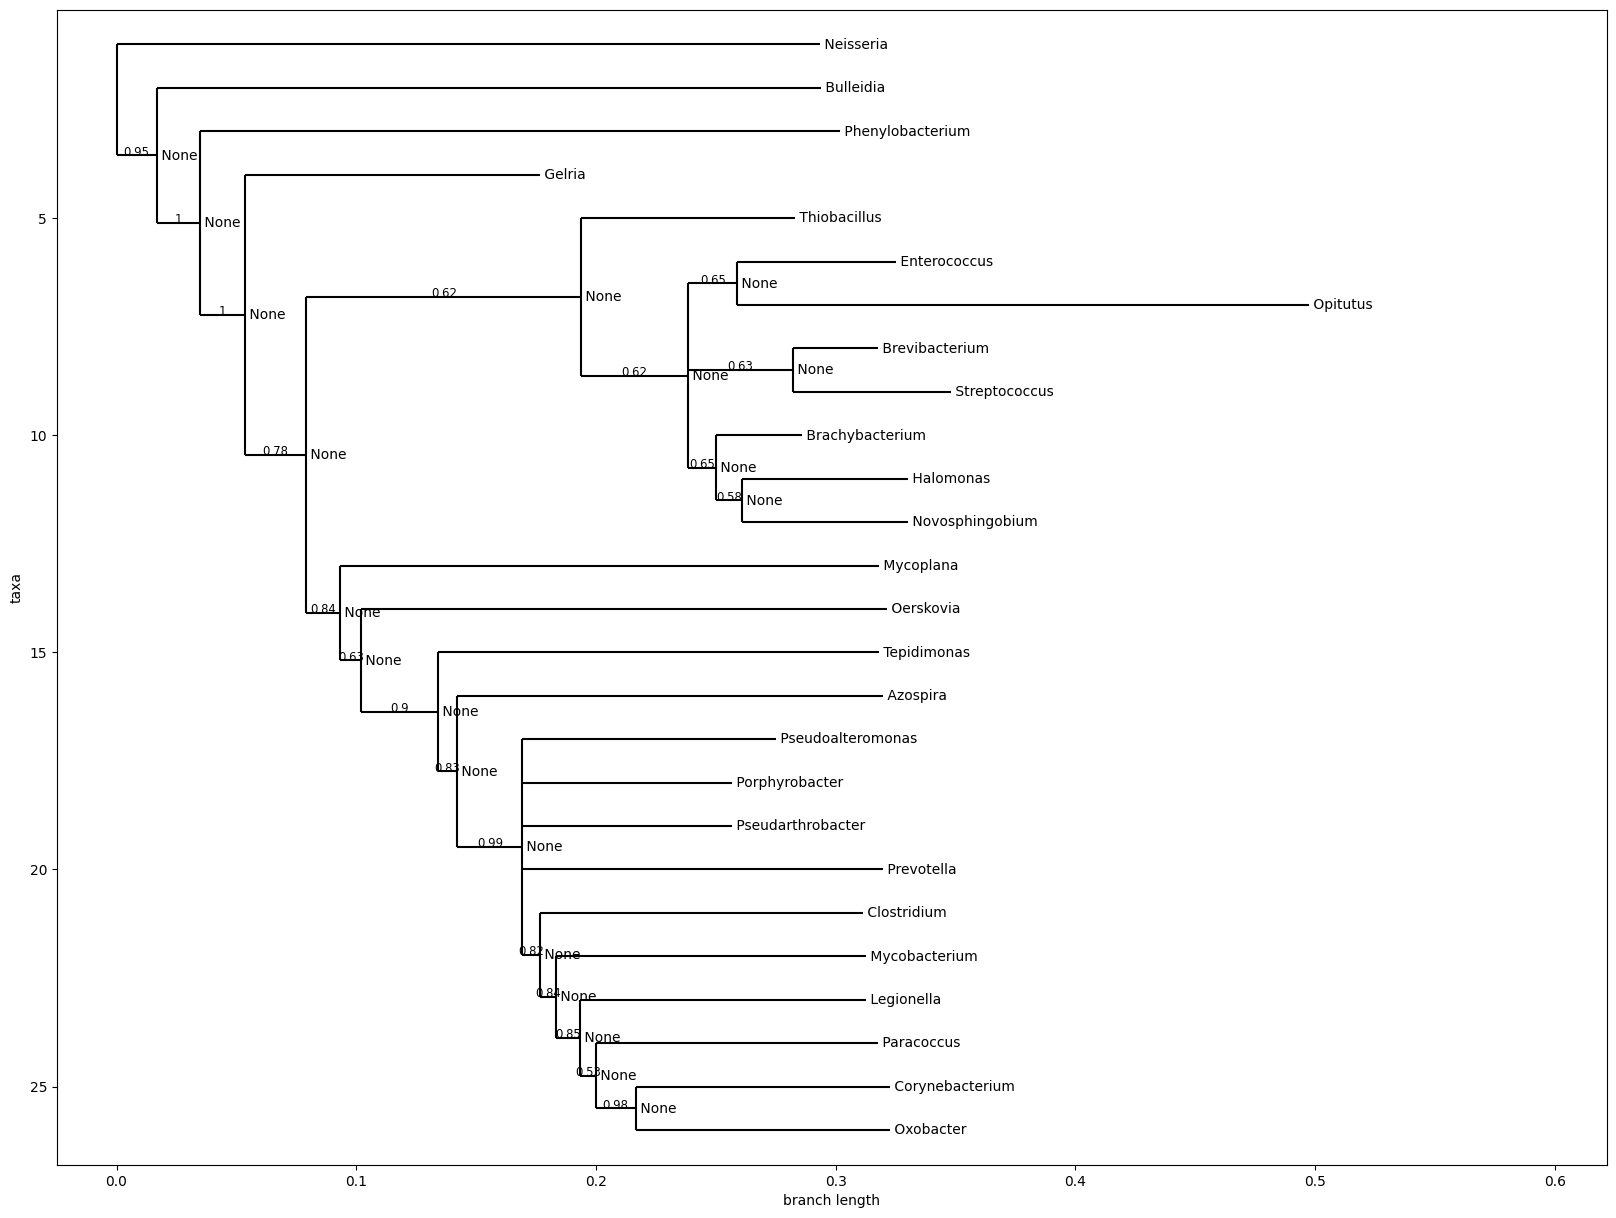

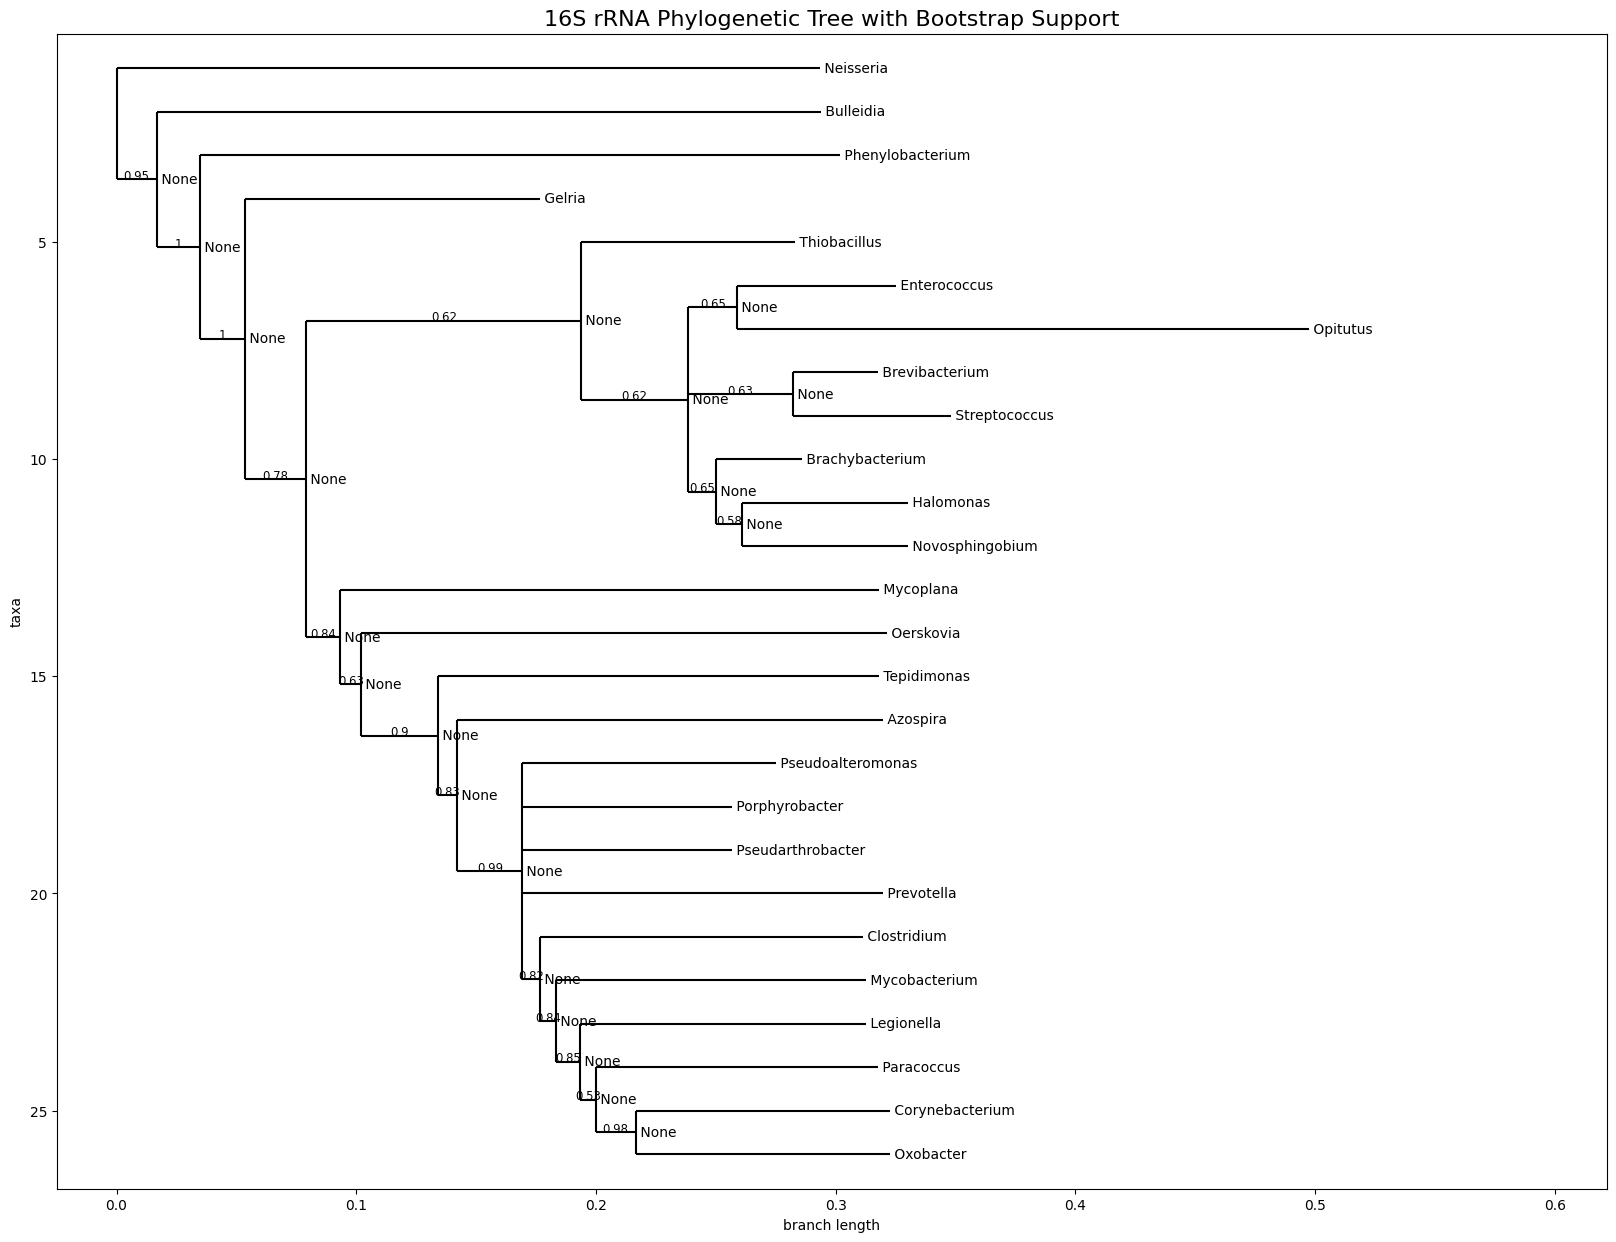

In [84]:
def plot_tree_with_annotations(consensus_tree, ax):
        
    # Draw tree with bootstrap values
    Phylo.draw(consensus_tree, 
               axes = ax, 
               show_confidence=True,
               label_func=lambda x: f"{x.name}" if x.confidence else x.name
    )

# Create the figure and axes outside the function
fig, ax = plt.subplots(figsize=(20, 15))

# Call the function, passing the external ax
plot_tree_with_annotations(consensus_tree, ax)

# Explicitly set the current axes to ensure the title is added to the correct subplot
plt.sca(ax)  # Set the current axes to `ax`
ax.set_title("16S rRNA Phylogenetic Tree with Bootstrap Support", fontsize=16)

# Display the plot
plt.show()

Note that there are two trees, that is because I didnt manage to put the title on the native Phylo tree and it was no possible to no draw the first one. The second one is more complete.

This consensus tree correspond to the actual checked_genera dataframe and it is done to compare with the consolidated community tree which would be explain better the dinamics of the systems.

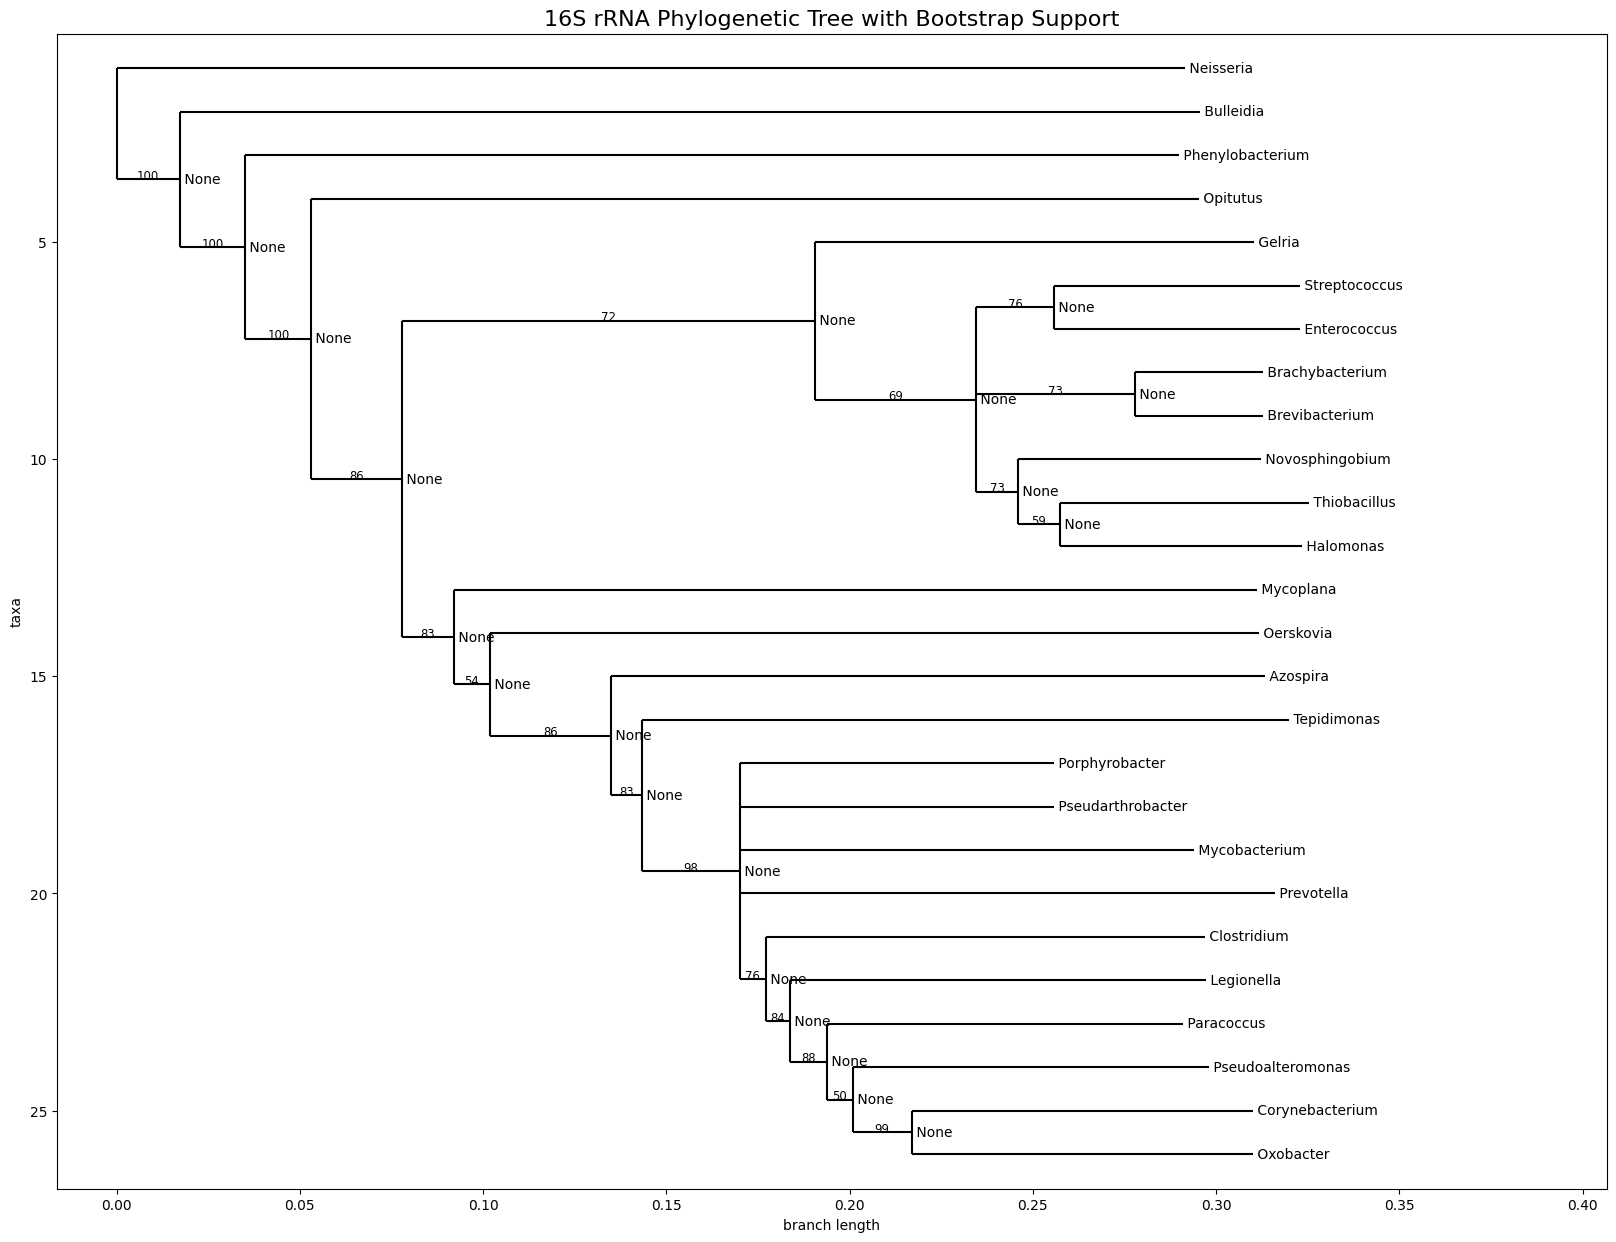

_________________________________________________________
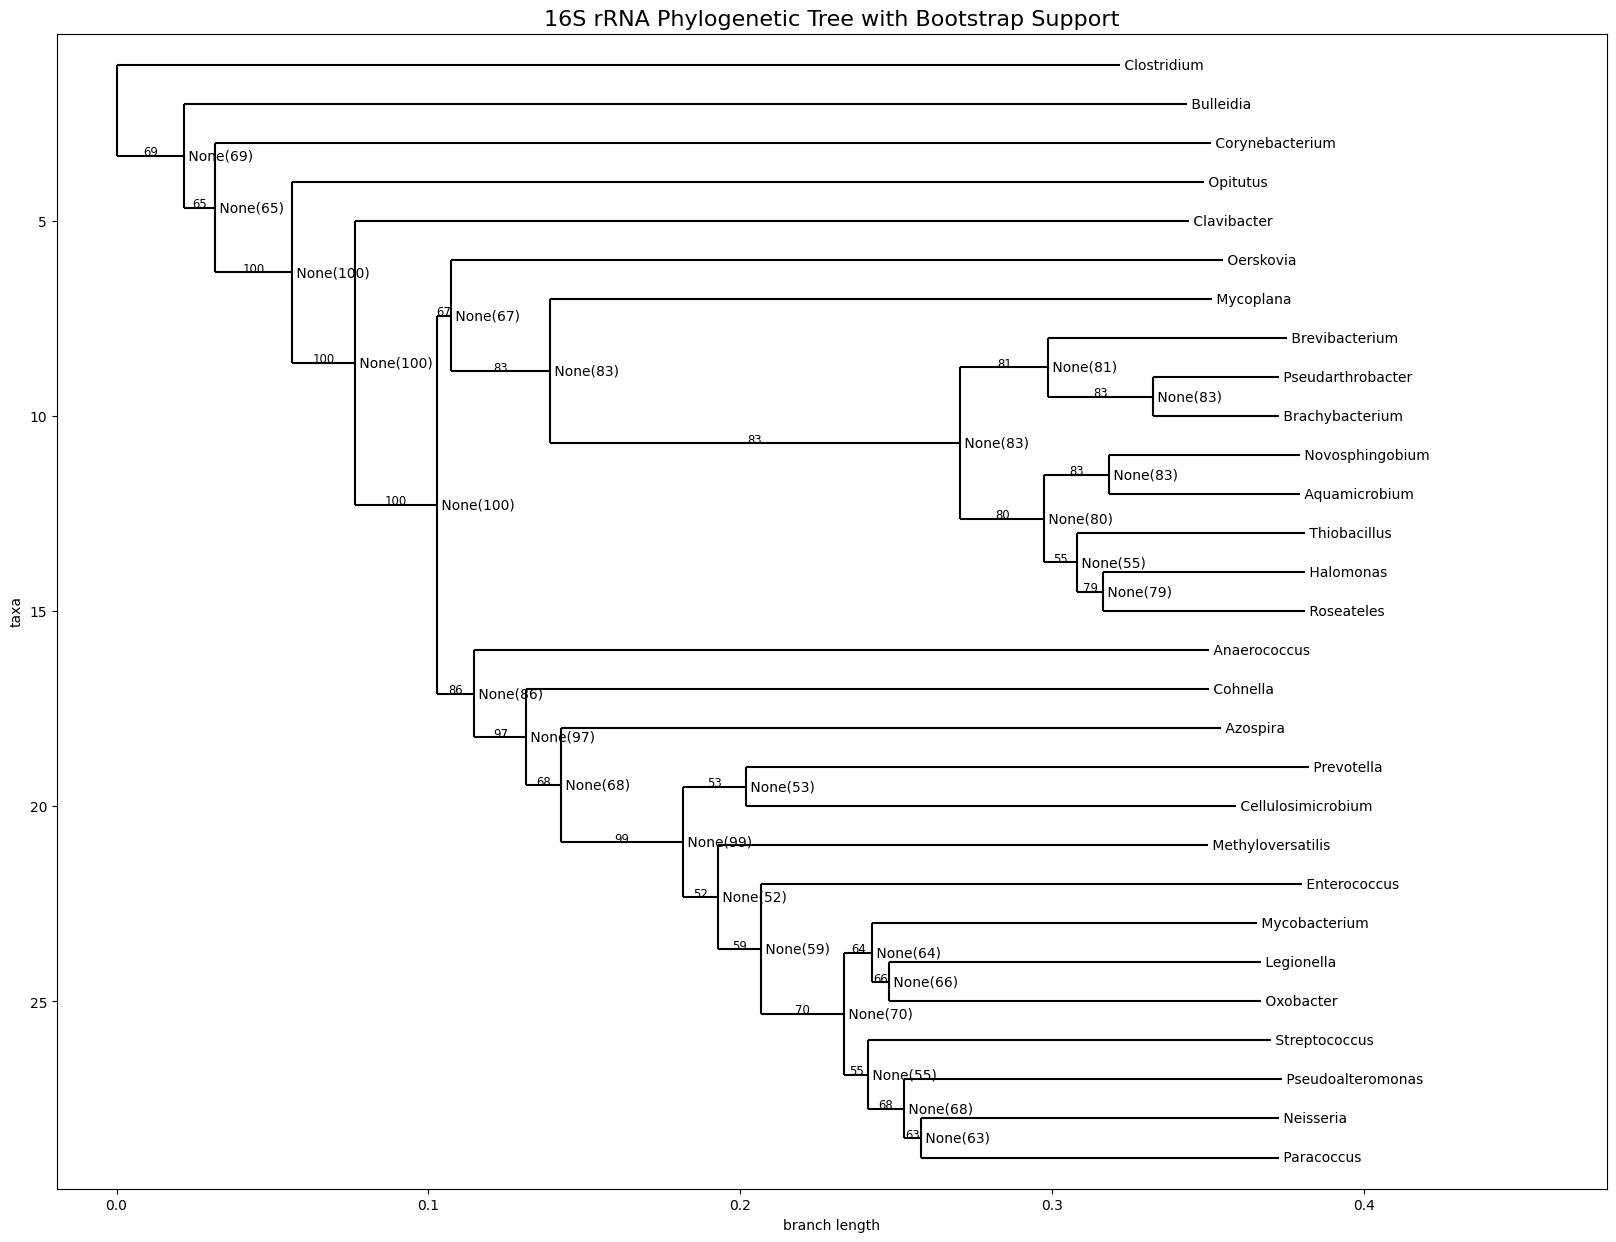

This is the consensus tree made with the dataframe checked from notebook 3. old version without the category 1 and more genera
# 9. Interpretation of the Concensus Tree for checked DataFrame
High Confidence Clades: Several clades show very high bootstrap support (100%), particularly at deeper nodes in the tree. For example, the clade containing Clavibacter, Oerskovia and related genera has 100% support, indicating these groupings are highly reliable.
The relationship between Brevibacterium, Pseudarthrobacter and Brachybacterium is well-supported with bootstrap values of 81-83%.

Moderate Confidence Clades: Many clades show moderate support (60-80%). For example:
The clade containing Mycobacterium and Legionella (64-66% support). The grouping of Paracoccus and Neisseria (63-68% support). These moderate values suggest some uncertainty in these relationships, though they're still reasonably supported.

Taxonomic Implications: The tree shows clear separation between major bacterial groups. For example, Clostridium, Bulleidia, and Corynebacterium form an early-branching group.
Aquamicrobium and Novosphingobium cluster together (83% support), suggesting they share a more recent common ancestor.
The clustering of Methyloversatilis with Enterococcus and related genera suggests some interesting evolutionary relationships that might warrant further investigation.

Data Quality: The presence of many moderate to high bootstrap values (>60%) suggests generally good quality sequence data and alignment.
The tree shows a good mix of deep and shallow relationships, indicating the analysis captured both ancient and recent evolutionary events.
There are no extremely low bootstrap values (<50%), which supports the overall robustness of the analysis.

# 10. Summarising the Results

In [85]:
def summarize_analysis(final_sequences, consensus_tree, output_dir):
    """Generate analysis summary"""
    summary = {
        'total_genera': len(final_sequences['Genus'].unique()),
        'sequences_retrieved': len(final_sequences),
        'avg_sequence_length': round(final_sequences['Sequence'].str.len().mean(), 4),
        'genera_list': ', '.join(final_sequences['Genus'].unique())
    }
    
    # Save summary
    with open(output_dir/'analysis_summary.txt', 'w') as f:
        for key, value in summary.items():
            f.write(f"{key}: {value}\n")
            
    return summary

In [86]:
Summary = summarize_analysis(final_sequences, consensus_tree, base_dir)
Summary

NameError: name 'final_sequences' is not defined

# 12 **Consensus Trees: Assessing the Role of Microbial Genera in Corrosion Failure of Water and Cooling Systems**
__Introduction__
In this notebook, we aim to visualize the consensus phylogenetic trees generated in the previous notebook 4_sequences_find.ipynb. The primary focus is to annotate these trees based on two key parameters:

Category: depending on the failure analysis category 1,2,3.
Abundance: The percentage of abundance of the genus on a sample, normalised to the sample.
By doing so, we seek to gain insights into the microbial community relationships and posterior metabolism pathways and its potential role in the system's failure.

__Objective__
Identify the genus that are associated with the failure analyis on a positive or inverse way.
__Methodology__
We use the ETE Toolkit for the visualization, employing various annotations and styles to represent the category and abundance data. The tree is scaled and styled to facilitate easy interpretation.

Annotating the netweick tree with the information of the respective dataframe with category and abundance for the genera found on the distintic sites/samples.

In [94]:
#separating the category 
category_dict = selected_taxa.iloc[0, 7:].to_dict()
# Create a new df just for genus and jointax 
jointax_df = selected_taxa[['level_0', 'level_6']].iloc[1:].reset_index(drop=True)
# Rename the columns to match what we need
jointax_df.columns = ['Jointax', 'Genus']

# Create a dictionary mapping "Genus" to "Jointax"
jointax_dict = jointax_df.set_index("Genus")["Jointax"].to_dict()

In [225]:
# color coding the tree depending on the source of the data checked, core or usual_suspects
def get_color_scheme(dataframe_name, row=None):
    """
    Determines color scheme based on dataframe type or Source column
    Args:
        dataframe_name: Name of the dataframe ('checked_taxa', 'core_taxa', or 'core_check_taxa')
        row: Optional row data if Source column needs to be checked
    Returns:
        Color hex code
    """
    # Base colors for different types
    color_scheme = {
        'checked_taxa': '#9370DB',  # Lilac
        'core_taxa': '#4169E1',     # Royal blue
        'usual_taxa': '#8B0000'     # Dark red
    }
    
    # If working with combined dataframe, check Source column
    if row is not None and isinstance(row, pd.Series) and 'Source' in row.index:
        source = row['Source']
        return color_scheme.get(source, 'black')
    
    # Otherwise return color based on dataframe name
    return color_scheme.get(dataframe_name, 'black')

In [226]:
# Load the tree 
t = Tree("data_tree/consensus_tree.newick", format=0)
# Define category colors with stronger values
category_colors = {
    'category_1': '#00CC00',  # Stronger green
    'category_2': '#FF8C00',  # Stronger orange
    'category_3': '#FF0000'   # Pure red
}
# Initialize an empty dictionary to store the aggregated data
aggregated_data = {}

# Loop through each row in the DataFrame
for index, row in selected_taxa.iterrows():
    genus = row['level_6']  # Using level_6 for genus
    if genus not in aggregated_data:
        aggregated_data[genus] = {'category_1': 0, 'category_2': 0, 'category_3': 0}
    
    # Loop through each site column
    site_columns = [col for col in selected_taxa.columns if col.startswith('site_')]
    for site_column in site_columns:
        category = category_dict[site_column]
        abundance = row[site_column]
        
        if category == 1:
            aggregated_data[genus]['category_1'] += abundance
        elif category == 2:
            aggregated_data[genus]['category_2'] += abundance
        elif category == 3:
            aggregated_data[genus]['category_3'] += abundance

category_colors = {'category_1': 'green', 'category_2': 'orange', 'category_3': 'red'}
# Create tree style
ts = TreeStyle()
ts.show_leaf_name = False  # Change to False to avoid double names
ts.branch_vertical_margin = 5 # Space between the branches
ts.scale = 120 # longer horizontally
ts.show_branch_support = False  # Show bootstrap values

nstyle = NodeStyle()
nstyle["size"] = 5
nstyle["fgcolor"] = "#666666"  # Darker grey
nstyle["hz_line_width"] = 2  # Horizontal line thickness
nstyle["vt_line_width"] = 2  # Vertical line thickness
# Function to add bootstrap labels
def layout(node):
    if not node.is_leaf():
        # Add bootstrap value without filtering
        if hasattr(node, "support"):
            # Make sure we display the support value as percentage
            support_value = node.support
            if support_value > 0 and support_value <= 1:  # If it's in decimal
                support_value *= 100
            bootstrap_face = TextFace(f"{support_value:.0f}%", fsize=8, fgcolor="blue")
            node.add_face(bootstrap_face, column=0, position="branch-top")

ts.layout_fn = layout

# Apply style and add annotations
for node in t.traverse():
    if node.is_leaf() and node.name in aggregated_data:
        # Extract name and bootstrap value if present
        name_parts = node.name.split('(')
        clean_name = name_parts[0].strip()
        # To handle color depending on the dataframe of origin 
        node_color = get_color_scheme(source_type)

        # Add name only once with controlled font size
        name_face = TextFace(clean_name, fsize=10, fgcolor=node_color)
        #for branch coloring
        node.img_style["fgcolor"] = node_color
        node.add_face(name_face, column=1, position="branch-right")
        
        # Add bootstrap value if present
        if len(name_parts) > 1:
            bootstrap = name_parts[1].rstrip(')')
            bootstrap_face = TextFace(f"({bootstrap})", fsize=8)
            node.add_face(bootstrap_face, column=1, position="branch-top")
        
        # Add abundance indicators
        column = 2  # Start circles after name and bootstrap
        for category, abundance in aggregated_data[clean_name].items():
            if abundance > 0:
                circle = CircleFace(radius= 3 + (abundance/5),
                                  color=category_colors[category],
                                  style="sphere")
                node.add_face(circle, column=column, position="branch-right")
                column += 1

# Add category legend 
legend_faces = []
categories = {
    'category_1': 'Normal Operation',
    'category_2': 'Early Warning',
    'category_3': 'System Failure'
}
for cat_num, desc in categories.items():
    legend_face = CircleFace(5, category_colors[f'category_{cat_num[-1]}'])
    # Include both category number and description
    legend_faces.append(TextFace(f"  {cat_num} - {desc}", fsize=8))
    legend_faces.append(legend_face)
    legend_faces.append(TextFace("   "))  # Spacing
ts.legend_position = 3  
ts.legend.add_face(TextFace("System Categories", fsize=10, bold=True), column=0)
for idx, face in enumerate(legend_faces):
    ts.legend.add_face(face, column=idx % 3)         

t.render("data_tree/iTOL_visual_first.png", w=1100, h= 1150, dpi=300, tree_style=ts)

{'nodes': [[59.36066467224691,
   57.68888984357913,
   66.66659263190807,
   63.49676586860151,
   0,
   None],
  [129.1666145484214,
   14.519690062555933,
   136.47254250808254,
   20.327566087578305,
   1,
   None],
  [110.50216038987502,
   100.85808962460233,
   117.80808834953618,
   106.66596564962471,
   2,
   None],
  [176.70701837473248,
   46.46300820017898,
   184.01294633439363,
   52.27088422520136,
   3,
   None],
  [174.42903003691015,
   155.2531710490257,
   181.7349579965713,
   161.06104707404805,
   4,
   None],
  [238.44649319064507,
   78.40632633780203,
   245.75242115030625,
   84.21420236282441,
   5,
   None],
  [238.3558996839453,
   232.10001576024933,
   245.66182764360644,
   237.90789178527172,
   6,
   None],
  [270.7854527112892,
   110.34964447542508,
   278.0913806709504,
   116.15752050044746,
   7,
   None],
  [289.4973954015734,
   353.8503870450736,
   296.80332336123456,
   359.658263070096,
   8,
   None],
  [340.6388911192015,
   203.58560766

### Phylogenetic Tree of checked_taxa

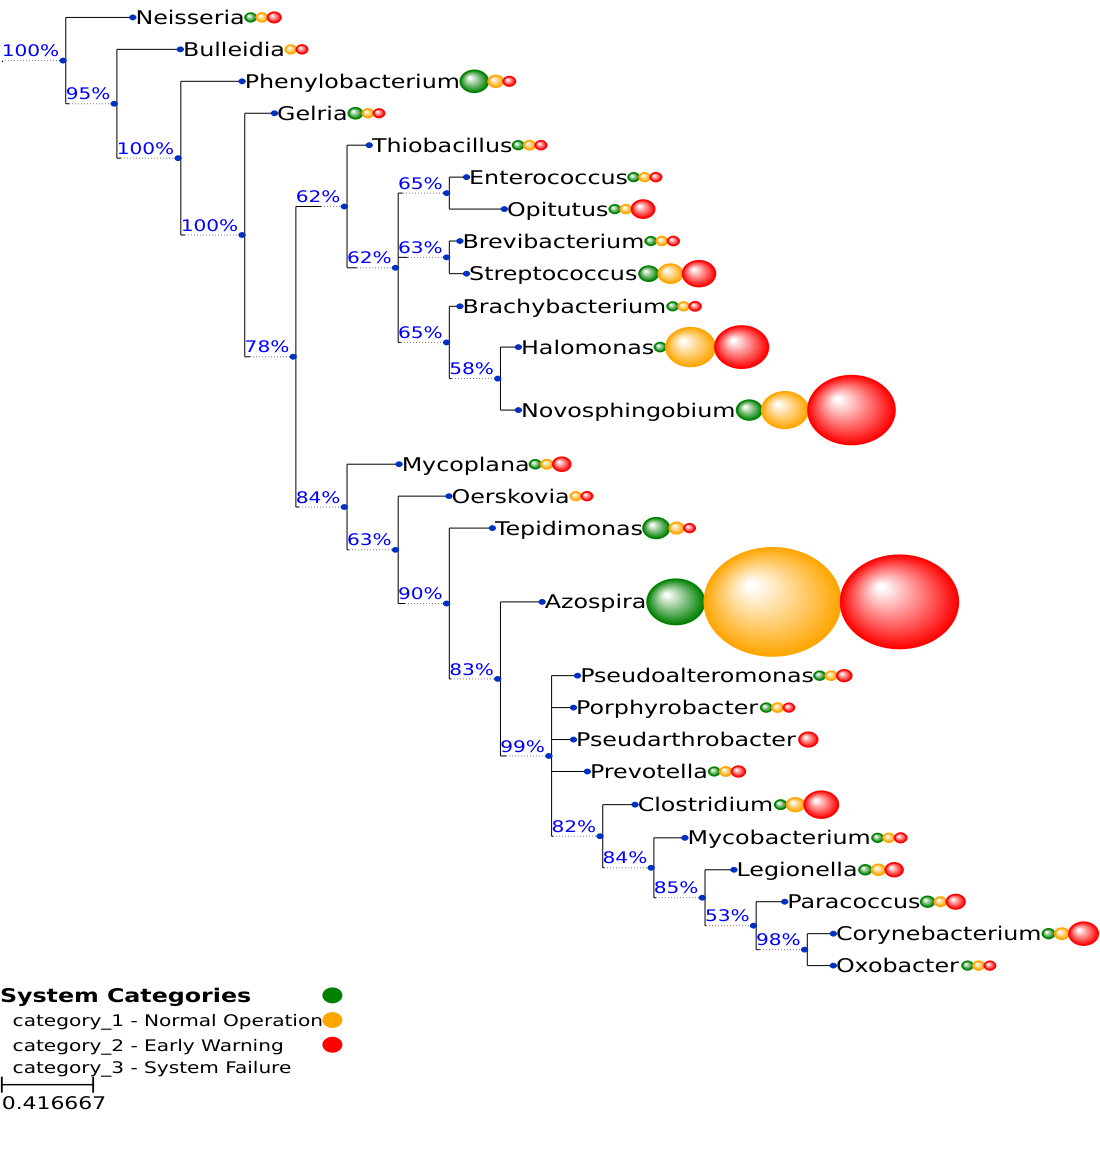
The annotated phylogenetic tree allows us to make several key observations:

Relevance of Genera: The tree highlights 15 genera as the most relevant in this study, those were found on previous notebooks and correspond to the genera that show a statistically significant varianz on abundance in operational heat and coolign systems, and have been clasified on three categories of failure: 
* 1-Green-->  systems with no failure  
* 2-Orange--> sistems starting to show failure  
* 3-Red -->   systems with detected failure  
Some systems present on all category and the abundance increase with increasing the failure, such are 
Protective Factors: Some genera are present across all categories but show an inverse relationship with system failure, suggesting a possible protective role.
Conclusion
While correlation does not imply causation, the statistical analysis and filtering of bacteria enable us to focus on specific genera for more comprehensive studies involving physicochemical factors. This could help us understand their influence on the system's failure or success. Additionally, some branches of the tree are exclusively associated with failed systems, warranting a more detailed metabolic study.

In [ ]:
# New names for the first 7 columns
new_names = ['Category_row', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']

# Change the values in the first row
select.iloc[0, :7] = new_names

In [ ]:
# Saving the file for another day
select.to_excel("data/select_annotate.xlsx")

In [ ]:
from ete3 import Tree, TextFace

# Load the tree
t = Tree("data/consensus_tree.newick", format=0) 

# Metabolic data 
metabolic_data = {
          'Clostridium': 'Pathway_Z',
      'Corynebacterium': 'Pathway_A',
               'Gelria': 'Pathway_B',
          'Haemophilus': 'Pathway_C',
            'Halomonas': 'Pathway_D',
           'Legionella': 'Pathway_E',
            'Oerskovia': 'Pathway_F',
            'Oxobacter': 'Pathway_G',
        'Porphyromonas': 'Pathway_H',
              'Psb-m-3': 'Pathway_I',
    'Pseudarthrobacter': 'Pathway_J',
    'Pseudoalteromonas': 'Pathway_K',
          'Rhodobacter': 'Pathway_L',
           'Roseateles': 'Pathway_M',
            'Roseococc': 'Pathway_N'
}

# Annotate the tree
for leaf in t.iter_leaves():
    if leaf.name in metabolic_data:
        metabolic_info = TextFace(metabolic_data[leaf.name])
        leaf.add_face(metabolic_info, column=1, position="branch-right")

# Show or render the tree
t.show()
# Render the tree
#t.render("%%inline", w=800, units="px", tree_style=ts)